# $\bm{12}$ $\enspace$ **权重衰退**

权重衰退的简单方法是通过线性函数 $f(\bm{x})=\bm{w}^T\bm{w}$ 中的权重向量的某个范数来度量其复杂性，例如 $\Vert \bm{w}\Vert^2$。要保证权重向量比较小，最常用方法是将其范数作为惩罚项加到最小化损失的问题中。将原来的训练目标最小化训练标签上的预测损失，调整为最小化预测损失和惩罚项之和。如果权重向量增长太大，我们的学习算法可能会更集中于最小化权重范数 $\Vert \bm{w}\Vert^2$。

线性回归中，损失函数如下：
$$
    L(\bm{w},b)=\frac{1}{n}\sum_{i=1}^n \frac{1}{2}\biggl(\bm{w}^T\bm{x}^{(i)}+b-y^{(i)} \biggr)^2
$$
其中 $\bm{x}^{(i)}$ 为样本 $i$ 的特征，$y^{(i)}$ 是样本 $i$ 的标签，$(\bm{w},b)$ 是权重和偏置参数。为了惩罚权重向量的大小，我们必须以某种方式在损失函数中添加 $\Vert w\Vert^2$，通过正则化常数 $\lambda$ 来描述这种权衡，这是一个非负超参数，我们使用验证数据拟合：
$$
    L(\bm{w},b)+\frac{\lambda}{2}\Vert w\Vert^2
$$

$L_2$ 正则化回归的小批量随机梯度下降更新如下式：
$$
    \bm{w}\leftarrow (1-\eta \lambda)\bm{w}-\frac{\eta}{\vert \mathcal{B} \vert}\sum_{i\in \mathcal{B}}\bm{x}^{(i)}\bigl(\bm{w}^T\bm{x}^{(i)}+b-y^{(i)}\bigr)
$$
我们根据估计值与观测值之间的差异来更新 $\bm{w}$。然而，我们同时也在试图将 $\bm{w}$ 的大小缩小到 $0$，这也是这种方法时常被称为权重衰减的原因。

## $\bm{12.1}$ $\enspace$ **高维线性回归**

In [21]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先，我们像以前一样生成一些数据，生成公式如下：
$$
    y=0.05+\sum_{i=1}^d 0.01x_i+\epsilon\ \mathrm{where}\ \epsilon\sim \mathcal{N}(0,0.01^2)
$$
我们选择标签是关于输入的线性函数。标签同时被均值为 $0$，标准差为 $0.01$ 的高斯噪声破坏。为了是过拟合的效果更加明显，我们可以将问题的维度增加到 $d=200$，并使用一个只包含 $20$ 个样本的小训练集。

In [22]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## $\bm{12.2}$ $\enspace$ **从零开始实现**

**初始化模型参数**

首先，我们定义一个函数来随机初始化模型参数。

In [23]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

**定义 $L_2$ 范数惩罚**

In [24]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

**定义训练代码实现**

In [25]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(
        xlabel="epochs",
        ylabel="loss",
        yscale="log",
        xlim=[5, num_epochs],
        legend=["train", "test"],
    )
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加L2范数惩罚项
            # 广播机制使 l2_penalty(w) 成为一个长度为 batch_size 的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(
                epoch + 1,
                (
                    d2l.evaluate_loss(net, train_iter, loss),
                    d2l .evaluate_loss(net, test_iter, loss)
                )
            )
    print("w的L2范数是: ", torch.norm(w).item())

**忽略正则化训练**

w的L2范数是:  14.161983489990234


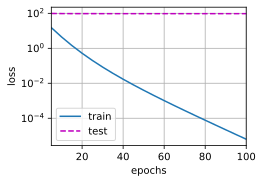

In [26]:
train(lambd=0)

**使用权重衰减**

w的L2范数是:  0.384232759475708


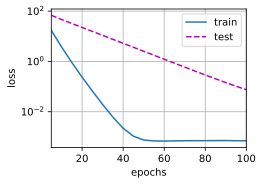

In [27]:
train(lambd=3)

由于权重衰减在神经⽹络优化中很常用，深度学习框架为了便于我们使⽤权重衰减，将权重衰减集成到优化算法中，以便与任何损失函数结合使用。此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分仅依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。

在下面的代码中，我们在实例化优化器时直接通过 `weight_decay` 指定 weight decay 超参数。默认情况下，PyTorch 同时衰减权重和偏移。这里我们只为权重设置了 `weight_decay`，所以偏置参数 $b$ 不会衰减。

In [31]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数: ', net[0].weight.norm().item())

w的L2范数:  13.790355682373047


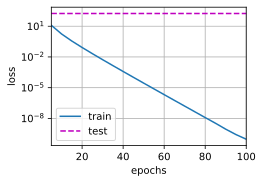

In [32]:
train_concise(0)

w的L2范数:  0.43442559242248535


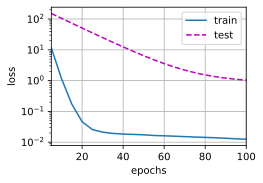

In [33]:
train_concise(3)